In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm
import pandas as pd
from os.path import expanduser
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
import imodelsx.util
from os.path import dirname
import pickle as pkl
import json
from copy import deepcopy
from numpy.linalg import norm
from math import ceil
from imodelsx.qaemb.qaemb import QAEmb, get_sample_questions_and_examples
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
extract = __import__('00_extract')
from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from neuro.ecog.config import ECOG_DIR
import dvu
from neuro import analyze_helper
dvu.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cols = None
for folders in ['words', 'sec_1.5', 'sec_6']:
    df_ex = f'/home/chansingh/mntv1/ecog/features___qs_35_stable/gpt-4o-mini/sec_6/___podcasts-story___.csv'

    cols_ = list(pd.read_csv(df_ex).columns[1:])
    if cols is None:
        cols = cols_
    else:
        assert (cols == cols_)
    assert len(cols) == 35

In [4]:
dec_perfs = joblib.load('decoding_corrs.jbl')
# save only 3-sec decoding
dec_perfs = dec_perfs[:, -35:]

ORDERING = ['Does the sentence include a direct speech quotation?', 'Does the sentence include dialogue?', 'Does the text describe a mode of communication?', 'Does the sentence involve spatial reasoning?', 'Does the sentence describe a visual experience or scene?', 'Does the sentence contain a negation?', 'Does the sentence involve an expression of personal values or beliefs?', 'Does the sentence contain a proper noun?', 'Does the sentence involve a description of physical environment or setting?', 'Is time mentioned in the input?', 'Does the sentence describe a relationship between people?', 'Does the sentence describe a physical sensation?', 'Does the input describe a specific texture or sensation?', 'Does the sentence describe a personal reflection or thought?', 'Does the sentence involve a discussion about personal or social values?', 'Does the input contain a number?', 'Does the sentence describe a physical action?', 'Does the sentence describe a sensory experience?', 'Is the sentence reflective, involving self-analysis or introspection?',
            'Does the input involve planning or organizing?', 'Does the sentence mention a specific location?', 'Does the sentence involve the mention of a specific object or item?', 'Does the sentence express a sense of belonging or connection to a place or community?', 'Does the input contain a measurement?', 'Does the text include a planning or decision-making process?', 'Is the sentence abstract rather than concrete?', "Does the sentence express the narrator's opinion or judgment about an event or character?", 'Does the text describe a journey?', 'Does the sentence include a personal anecdote or story?', 'Does the sentence describe a personal or social interaction that leads to a change or revelation?', 'Does the sentence describe a specific sensation or feeling?', 'Is the input related to a specific industry or profession?', 'Does the sentence contain a cultural reference?', 'Does the input include a comparison or metaphor?', 'Does the sentence include technical or specialized terminology?']
dec_perfs = pd.DataFrame(dec_perfs, columns=cols)[ORDERING].values
cols = ORDERING

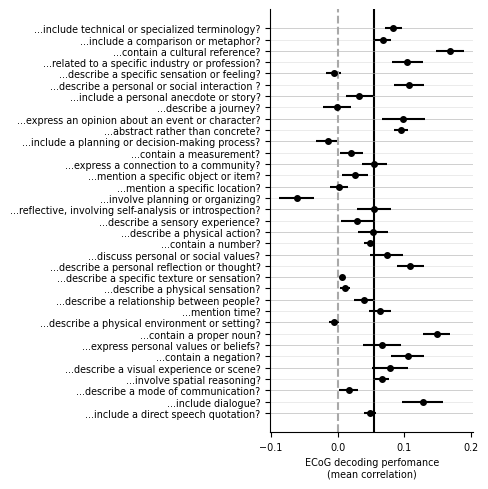

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.errorbar(
    # corrs_df_subject[plot_val],
    dec_perfs.mean(axis=0),
    range(len(cols)),
    xerr=dec_perfs.std(axis=0) / np.sqrt(dec_perfs.shape[0]),
    # xerr=np.sqrt(
    # r_df[plot_val] * (1-r_df[plot_val])
    # / r_df['num_test']),
    alpha=1,
    # label=subject.upper().replace('UT', ''),
    ms=4,
    color='black',
    fmt='o')
plt.axvline(
    dec_perfs.mean(),
    linestyle='-',
    color='black',
    zorder=-1000)

plt.axvline(0, color='darkgray', linestyle='--')

fs = 'x-small'
# add horizontal bars
labs = [analyze_helper.abbrev_question(q) for q in cols]
plt.yticks(range(len(cols)), labs, fontsize=fs)
plt.xlabel(
    'ECoG decoding perfomance\n(mean correlation)', fontsize=fs)
plt.xticks(fontsize=fs)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
# Get the current tick locations
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Select every other tick
# ax.set_xticks(xticks[::2])
ax.set_yticks(yticks[::2], minor=True)
ax.grid(True, which='major', linewidth=0.7, alpha=0.6, axis='y')

for i, line in enumerate(ax.yaxis.get_gridlines()):
    if i % 2 == 1:  # Hide every second gridline
        line.set_alpha(0.25)

# annotate with baseline and text label
# plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig('decoding_corrs.png', dpi=300, bbox_inches='tight')